In [11]:
import json
from collections import Counter
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import ssl
import numpy as np 
import seaborn as sns
import random
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/volthai7us/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import tensorflow as tf

In [13]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.13.0-rc1
[]


In [14]:
def clean_and_split(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

def preprocess_speaker(speaker): 
    file_path = f'./data/transcripts/friends-1-227-{speaker}-pair.json'

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        
    all_answers = [item['answer'] for item in data]

    all_answers = [clean_and_split(answer) for answer in all_answers]

    stop_words = set(stopwords.words('english'))
    
    
    def remove_stopwords(answer):
        filtered_words = [word for word in answer if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    all_answers = [remove_stopwords(answer) for answer in all_answers]

    return all_answers

In [15]:
speakers = ("Rachel", "Chandler", "Phoebe", "Monica", "Ross", "Joey")

all_data = []

for index, speaker in enumerate(speakers):
    all_answers = preprocess_speaker(speaker=speaker)
    speaker_data = [(answer, index) for answer in all_answers]
    sample_size = min(5000, len(speaker_data))
    random_sample = random.sample(speaker_data, sample_size)
    all_data.extend(speaker_data)
    
speaker_combinations = []

for speaker1 in speakers:
    for speaker2 in speakers:
        combination = f"{speaker1}-{speaker2}"
        speaker_combinations.append(combination)

df = pd.DataFrame(all_data, columns=['text', 'speaker'])
df = df.sample(frac=1)



In [16]:
docs = list(df['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [17]:
X = docs 
y = df['speaker']
print(X.shape, y.shape)

(44485, 12508) (44485,)


In [18]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [19]:
def train_and_test(X, y, model=GaussianNB):
    print("-" * 50)
    print("Model: ", model.__name__)
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

    m = model() 
    %time m.fit(X_train, y_train)

    y_pred_train = m.predict(X_train)
    y_pred_test = m.predict(X_test)
    print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
    print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
    
    print(classification_report(y_test, y_pred_test, target_names=speakers))
    
    cm = confusion_matrix(y_test, y_pred_test, normalize='true')
    # print('Confusion matrix\n', cm)

    cm_matrix = pd.DataFrame(data=cm, columns=speakers, index=speakers)
    sns.heatmap(cm_matrix, annot=True , cmap='YlGnBu')
    plt.show()

--------------------------------------------------
Model:  LinearSVC
CPU times: user 1.51 s, sys: 523 ms, total: 2.03 s
Wall time: 2.51 s

Training Accuracy score: 0.5304316061593796
Testing Accuracy score: 0.27065302911093625
              precision    recall  f1-score   support

      Rachel       0.28      0.36      0.31      1633
    Chandler       0.23      0.26      0.25      1470
      Phoebe       0.27      0.19      0.22      1316
      Monica       0.26      0.24      0.25      1467
        Ross       0.29      0.28      0.28      1575
        Joey       0.29      0.29      0.29      1436

    accuracy                           0.27      8897
   macro avg       0.27      0.27      0.27      8897
weighted avg       0.27      0.27      0.27      8897



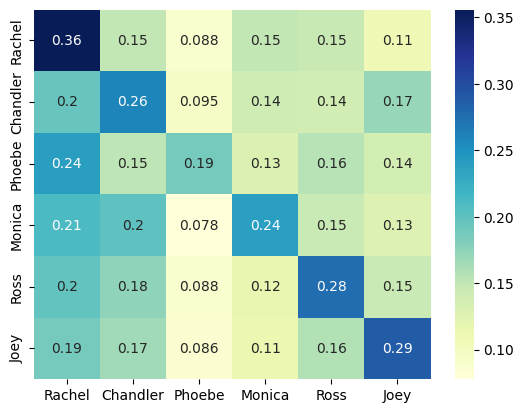

In [20]:
train_and_test(X=X, y=y, model=LinearSVC)

In [11]:
from transformers import TFXLNetModel, XLNetTokenizer

In [70]:
def create_xlnet(mname, number_of_classes):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(512,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(number_of_classes, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [71]:
xlnet_model = 'xlnet-large-cased'

In [72]:
xlnet = create_xlnet(xlnet_model, 1)

/Users/volthai7us/Library/Python/3.9/lib/python/site-packages/keras/src/initializers/initializers.py:120: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.

Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of T

In [73]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['speaker'])

In [74]:
text = df['text']
labels = df['speaker']


X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.15, random_state=196)

In [75]:
def get_inputs(text, tokenizer, max_len=512):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in text]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

In [76]:
def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [77]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [78]:
inp_tok, ids, segments = get_inputs(X_train, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [79]:
inp_tok.shape

(37812, 512)

In [80]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [81]:
hist = xlnet.fit(x=inp_tok, y=y_train, epochs=4, batch_size=2, validation_split=.15, callbacks=callbacks)

Epoch 1/4


   14/16070 [..............................] - ETA: 46:39:14 - loss: -71.0012 - accuracy: 0.4286 - precision_1: 0.8182 - recall_1: 0.9000

KeyboardInterrupt: 